# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


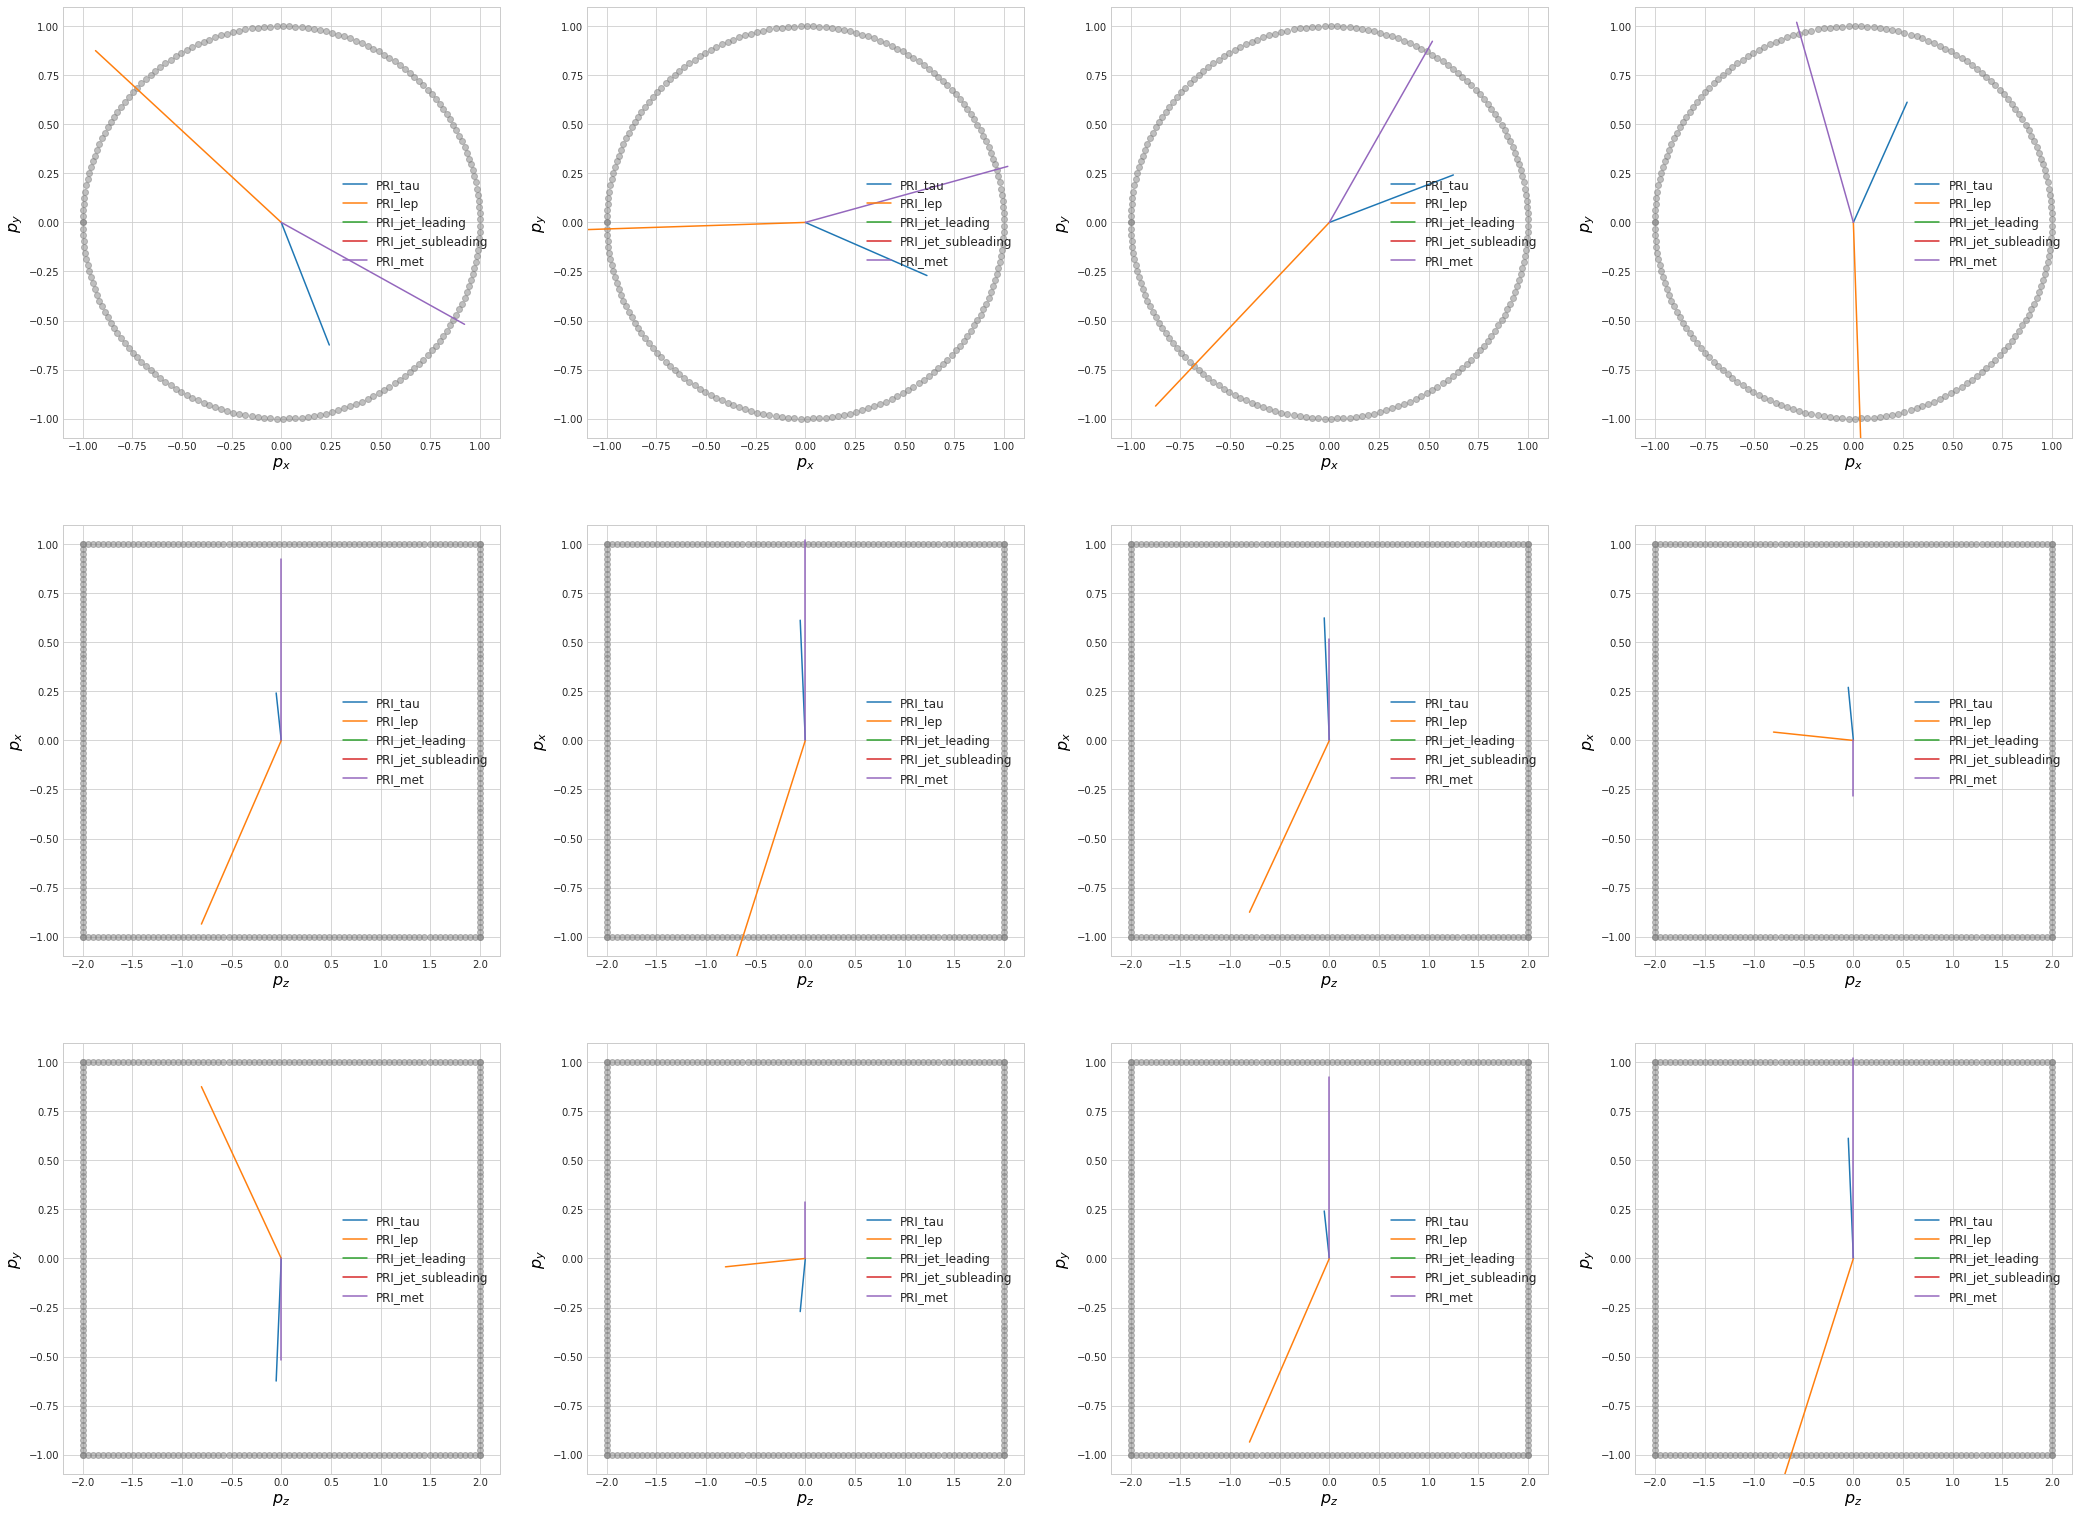

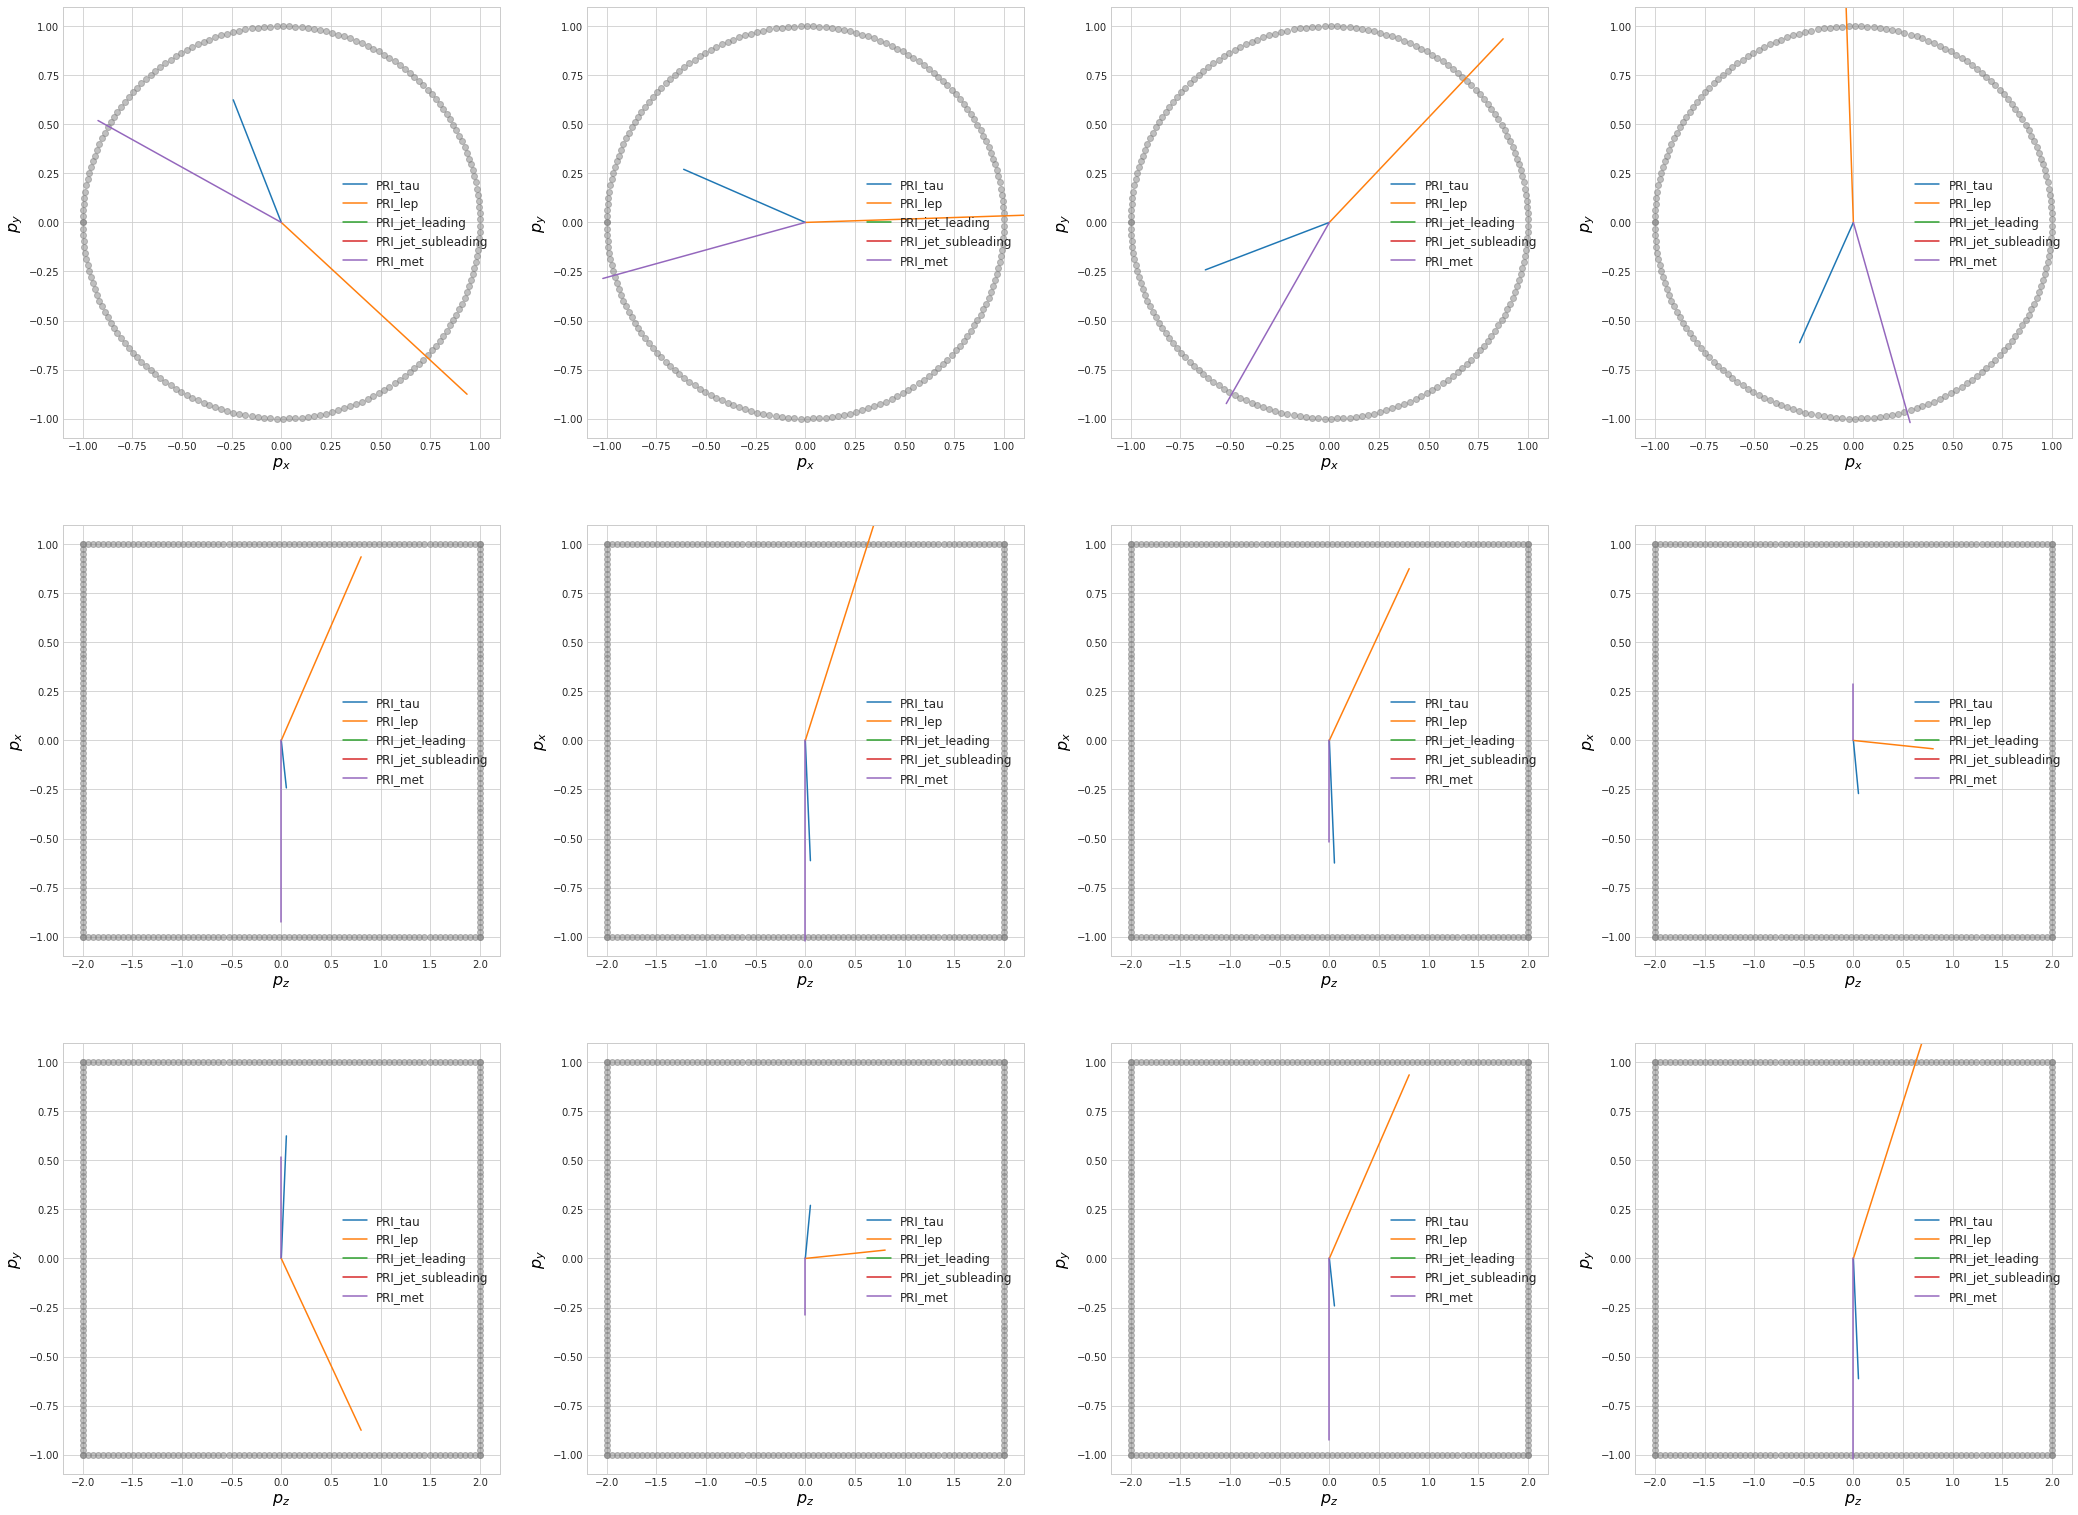

In [6]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.804s 


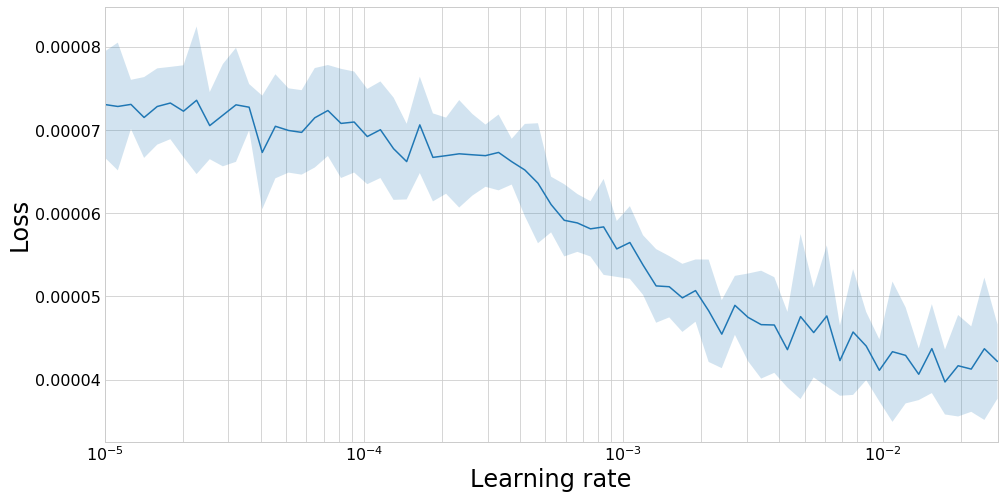

______________________________________



In [11]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [5]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

In [6]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

Cycle 1 ended
1 New best found: 3.8261528604034695e-05
2 New best found: 3.633730248063332e-05
Cycle 2 ended
3 New best found: 3.568633344491102e-05
4 New best found: 3.497413987036184e-05
5 New best found: 3.471269164455886e-05
6 New best found: 3.3828552826563114e-05
Cycle 3 ended
7 New best found: 3.37706514682865e-05
10 New best found: 3.345858071704482e-05
12 New best found: 3.317779776751061e-05
13 New best found: 3.299800950521128e-05
14 New best found: 3.284652892105074e-05
Cycle 4 ended
saving snapshot 4
23 New best found: 3.277188319522623e-05
24 New best found: 3.259584048993766e-05
25 New best found: 3.247278246313251e-05
26 New best found: 3.233502031881358e-05
27 New best found: 3.2234656692760334e-05
28 New best found: 3.219965768134757e-05
30 New best found: 3.218558754848544e-05
Cycle 5 ended
31 New best found: 3.217669284954666e-05
44 New best found: 3.21589

KeyboardInterrupt: 

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

## Response on validation data without TTA

In [ ]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
val_df = convert_to_df(val_fy.source)

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

In [ ]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

In [ ]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [ ]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                           input_pipe=None, rot_mult=8)

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

In [ ]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

In [ ]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

In [ ]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [ ]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, cut_kde)

In [ ]:
score_test_data(test_fy.source, cut_mean)

# Test scoring - With TTA

In [ ]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                            input_pipe=None, rot_mult=8)

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

In [ ]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)